# Customer churn

Customers began to leave Beta-Bank. Every month. A little, but noticeable. Banking marketers figured it was cheaper to keep current customers than to attract new ones.

It is necessary to predict whether the client will leave the bank in the near future or not. You are provided with historical data on customer behavior and termination of agreements with the bank.

Build a model with an extremely large *F1*-measure. To pass the project successfully, you need to bring the metric to 0.59. Check the *F1*-measure on the test set yourself.

Additionally measure *AUC-ROC*, compare its value with *F1*-measure.

Data Source: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

# 1. Data preparation

In [1]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder 
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve 
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestClassifier

data = pd.read_csv('/datasets/Churn.csv')
print(data.dtypes)
data.head()


RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure             float64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


***
- There are missing values
- Data types in Surname, Geography and Geder columns are not suitable
***

In [2]:
data = data.drop(['Surname', 'CustomerId', 'RowNumber'], axis=1) 
print(data.isnull().sum())
tenure_avg = data['Tenure'].median()
data['Tenure'] = data['Tenure'].fillna(value = tenure_avg)


data_new = pd.get_dummies(data, drop_first=True)
data_new

CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5.0,0.00,2,1,0,96270.64,0,0,0,1
9996,516,35,10.0,57369.61,1,1,1,101699.77,0,0,0,1
9997,709,36,7.0,0.00,1,0,1,42085.58,1,0,0,0
9998,772,42,3.0,75075.31,2,1,0,92888.52,1,1,0,1


- Delete the Surname column
- Replace all Nun in the Tenure column with the median
- Also, all the remaining string values will be replaced by numeric ones


In [3]:
train, valid, test = np.split(data_new.sample(frac=1, random_state=42),
                                  [int(.6*len(data_new)), int(.8*len(data_new))])

# variables for features and target feature
features_train = train.drop(['Exited'], axis=1)
target_train = train['Exited']

features_valid = valid.drop(['Exited'], axis=1)
target_valid = valid['Exited']

features_test = test. drop(['Exited'], axis=1)
target_test = test['Exited']
print(train.shape)
print(valid.shape)
print(test.shape)

(6000, 12)
(2000, 12)
(2000, 12)


***Create 3 samples: Training, valid and test***

# 2. Research the problem

6252    0
4684    0
1731    0
4742    0
4521    0
       ..
7895    0
9590    0
7288    0
278     0
3252    0
Name: Exited, Length: 6000, dtype: int64


<AxesSubplot:>

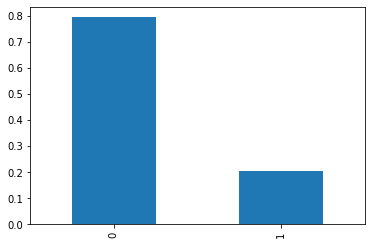

In [4]:
# for the value_counts() function to work, we convert the result to pd.Series
class_frequency = target_train.value_counts(normalize=(0, 1))
print(target_train)
class_frequency.plot(kind='bar')

***The number of positive and negative outcomes varies greatly, which negatively affects the training of the model***

# 3. Fight imbalance

In [5]:
model = LogisticRegression(random_state=12345)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print(f1_score(target_valid, predicted_valid))

model1 = LogisticRegression(random_state=12345, class_weight='balanced') # балансировка классов 
model1.fit(features_train, target_train)
predicted_valid_balanced = model1.predict(features_valid)
print(f1_score(target_valid, predicted_valid_balanced))

0.06263982102908278
0.44535743631881675


***When F1 classes are bolstered, the criterion rises ( So this is what is missing for core work)***

In [6]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.2) # уменьшение выборки в 10 раз 

downsample_model = LogisticRegression(random_state=12345, class_weight='balanced')
downsample_model.fit(features_downsampled, target_downsampled)
downsample_predicted_valid = downsample_model.predict(features_valid)

print("F1:", f1_score(target_valid, downsample_predicted_valid))

F1: 0.44700082169268696


In [7]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4) # увелечение выборки в 4 раз 

upsample_model = LogisticRegression(random_state=12345, class_weight='balanced')
upsample_model.fit(features_upsampled, target_upsampled)
upsample_predicted_valid = upsample_model.predict(features_valid)
print("F1:", f1_score(target_valid, upsample_predicted_valid))

F1: 0.44535743631881675


- By increasing and decreasing the sample, you can see that the F1 criterion has grown. Especially when the sample is reduced.
- I think further you can safely use features_downsampled, target_downsampled to make the model more correct

0    0.59
1    0.41
dtype: float64


<AxesSubplot:>

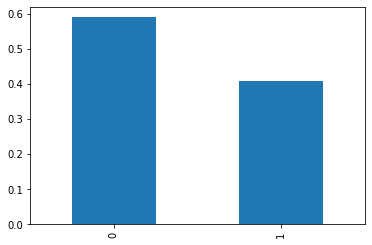

In [8]:
downsample_predicted_valid = pd.Series(downsample_model.predict(features_valid))
class_frequency = downsample_predicted_valid.value_counts(normalize=(0, 1))
print(class_frequency)
class_frequency.plot(kind='bar') 


0    0.59
1    0.41
dtype: float64


<AxesSubplot:>

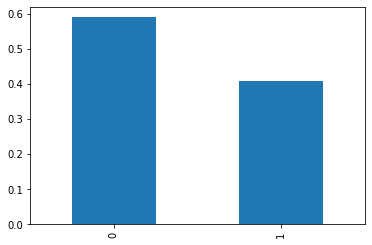

In [9]:
upsample_predicted_valid = pd.Series(upsample_model.predict(features_valid))
class_frequency = upsample_predicted_valid.value_counts(normalize=(0, 1))
print(class_frequency)
class_frequency.plot(kind='bar') 

In [10]:
features_train = features_upsampled
target_train  = target_upsampled

***Creating new data. Since the sample size has been reduced***

# 4. Model testing

In [11]:
%%time

best_result = 0
best_model = None
for depth in range(1, 20, 1):
        model = RandomForestClassifier(n_estimators=151, max_depth=depth, random_state=12345, class_weight='balanced')
        model.fit(features_train, target_train)
        predicted_valid = model.predict(features_valid)
        r2 = f1_score(predicted_valid, target_valid)
        if r2 > best_result:
            best_result = r2
            best_model = model
print(r2,'\n' ,best_model)

0.6149802890932983 
 RandomForestClassifier(class_weight='balanced', max_depth=11, n_estimators=151,
                       random_state=12345)
CPU times: user 17.6 s, sys: 170 ms, total: 17.8 s
Wall time: 17.8 s


***In the cell above, I found the maximum depth of trees***

***Max tree depth 11***

In [16]:
%%time

model = RandomForestClassifier(n_estimators=151, max_depth=11 , random_state=12345, class_weight='balanced')
model.fit(features_train, target_train)


CPU times: user 992 ms, sys: 930 µs, total: 993 ms
Wall time: 993 ms


RandomForestClassifier(class_weight='balanced', max_depth=11, n_estimators=151,
                       random_state=12345)

***Best model. Then I test everything on it.***

In [17]:
predictions_train = model.predict(features_train) # predictions on the training
predictions_valid = model.predict(features_valid) # predictions on valid
predictions_test = model.predict(features_test)

print("Best model")
print("MAE on training set: ", mean_absolute_error(target_train, predictions_train))
print("MAE on validation set: ", mean_absolute_error(target_valid, predictions_valid))
print("MAE on test set: ", mean_absolute_error(target_test, predictions_test))

Best model
MAE on training set:  0.054901960784313725
MAE on validation set:  0.1605
MAE on test set:  0.1875


In [18]:
predicted_valid = model.predict(features_valid)
predicted_test = model.predict(features_test)
predicted_train = model.predict(features_train)

print("F1:", f1_score(target_train, predicted_train)) # F1-score
print("F1:", f1_score(target_valid, predicted_valid)) # F1-score
print("F1:", f1_score(target_test, predicted_test)) # F1-score

F1: 0.9460008120178645
F1: 0.6356413166855845
F1: 0.5664739884393063


***F1 is much better than 0.57***

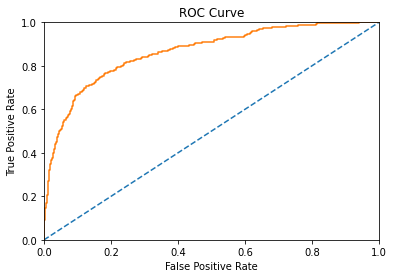

0.8642186957389404


In [19]:
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid) # FPR values, TPR values and considered thresholds
plt.figure()

# <plot>

# ROC curve of a random model (looks like a straight line)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()


auc_roc = roc_auc_score(target_valid, probabilities_one_valid) # random 0.5 (Best 1)
print(auc_roc)

***According to AUC-ROC, it can be judged that the model works***

# 5 Conclusion


The best model is Random Forest. Although it takes a long time, it has better accuracy.
- AUC-ROC has an accuracy of 0.86 This is a pretty good result and it is very different from the random 0.5 (this can be seen on the graph)
- F1: 0.64 on valid and 0.57 on test
- The best model is a decision forest with parameters (n_estimators=151, max_depth=11)
